In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import vgg16

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Sequential, optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import random
import os

%matplotlib inline

In [2]:
# settings for reproducibility
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

is_use_gpu = True
if is_use_gpu:
    gpu_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    os.environ['TF_USE_CUDNN'] = '1'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

Define locations of the train and validation datasets:

In [3]:
# each folder contains three subfolders in accordance with the number of classes
train_dir = './clean-dataset/train'
validation_dir = './clean-dataset/validation'

image_size = 224

## Experiment 1: Freezing all layers - Same as Transfer Learning

<h3>1. Freezing all layers</h3>

Create the model setting ``include_top`` parameter to ``False`` in order to exclude the fully-connected layers at the top of the network.

In [4]:
# Init the VGG model 
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fad19eef690> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fad1a1fab50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fadb831ad90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fad10170f50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fad10192210> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fad10197d10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fad1019f050> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fad10125710> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fad1012ef50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fad10133dd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fad10139b50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

<h3>2. Prepare the training and validation data</h3>

In [5]:
# Load the normalized images
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


<h3>3. Visualizing the datasets</h3>

In [6]:
# Utility function for quick class name access
def get_class_name(generator, image_id):
    # Get the image class and map its index with the names of the classes
    image_label_id = np.argmax(generator[image_id][1][0])
    classes_list = list(generator.class_indices.keys())
    return classes_list[image_label_id]

The shape of train images: (224, 224, 3)
The shape of validation images: (224, 224, 3)


Text(0.5, 1.0, 'Validation class name: tomato')

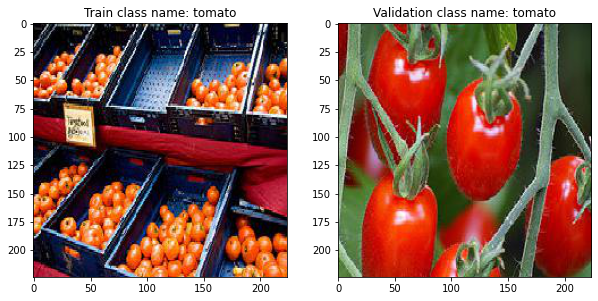

In [7]:
# Choose the image index for the visualization
image_id = 5

# Get the train image shape 
print("The shape of train images: {}".format(train_generator[image_id][0][0].shape))

# Get the validation image shape 
print("The shape of validation images: {}".format(validation_generator[image_id][0][0].shape))

# Visualize the train image example
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.imshow(train_generator[image_id][0][0])

# Show the train image class
plt.title("Train class name: {}".format(get_class_name(train_generator, image_id)))

# Visualize the validation image example
plt.subplot(122)
plt.imshow(validation_generator[image_id][0][0])

# show image class
plt.title("Validation class name: {}".format(get_class_name(validation_generator, image_id)))

<h3>4. Train the model</h3>

In [8]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6.0 steps, validate for 15.0 steps
Epoch 1/20
6/6 [==============================] - 6s 937ms/step - loss: 3.4718 - acc: 0.4000 - val_loss: 0.8491 - val_acc: 0.6267
Epoch 2/20
6/6 [==============================] - 3s 558ms/step - loss: 0.6608 - acc: 0.7150 - val_loss: 0.6130 - val_acc: 0.7333
Epoch 3/20
6/6 [==============================] - 3s 555ms/step - loss: 0.5476 - acc: 0.7717 - val_loss: 0.5616 - val_acc: 0.7800
Epoch 4/20
6/6 [==============================] - 3s 560ms/step - loss: 0.3403 - acc: 0.8583 - val_loss: 0.8117 - val_acc: 0.6867
Epoch 5/20
6/6 [==============================] - 3s 560ms/step - loss: 0.2827 - acc: 0.9017 - val_loss: 0.4417 - val_acc: 0.8067
Epoch 6/20
6/6 [==============================] - 3s 560ms/step - loss: 0.3605 - acc: 0.8517 - val_loss: 0.6821 - val_acc: 0.7867
Epoch 7/20
6/6 [==============================] - 3s 561ms/step - loss: 0.1410 - acc: 0.9567 - val_loss: 0.3466 - val_acc: 0.

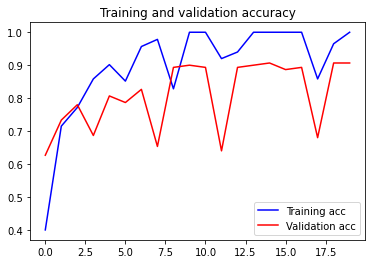

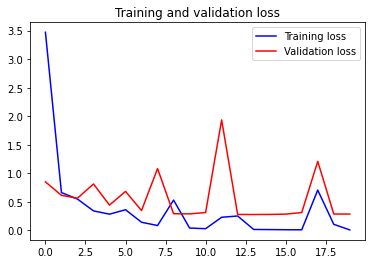

In [9]:
# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the model
model.save('all_freezed.h5')

# Run the function to illustrate accuracy and loss
visualize_results(history)

<h3>5. Show the errors</h3>

Let's define a couple of utility functions to avoid a code duplication in further experiments.

In [10]:
# Utility function for obtaining of the errors 
def obtain_errors(val_generator, predictions):
    # Get the filenames from the generator
    fnames = validation_generator.filenames

    # Get the ground truth from generator
    ground_truth = validation_generator.classes

    # Get the dictionary of classes
    label2index = validation_generator.class_indices

    # Obtain the list of the classes
    idx2label = list(label2index.keys())
    print("The list of classes: ", idx2label)

    # Get the class index
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("Number of errors = {}/{}".format(len(errors),validation_generator.samples))
    
    return idx2label, errors, fnames

In [11]:
# Utility function for visualization of the errors
def show_errors(idx2label, errors, predictions, fnames):
    # Show the errors
    for i in range(len(errors)):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

15/15 [==============================] - 1s 53ms/step
The list of classes:  ['pumpkin', 'tomato', 'watermelon']
Number of errors = 14/150


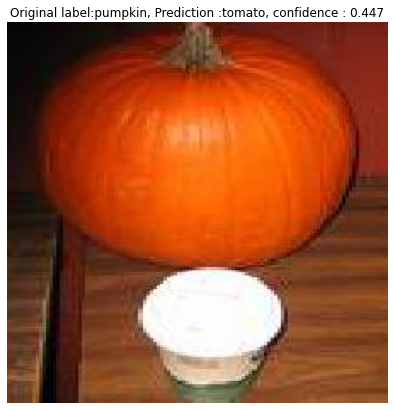

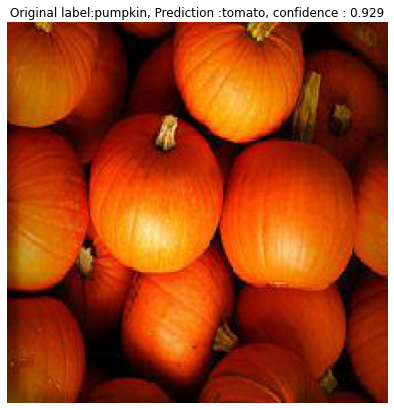

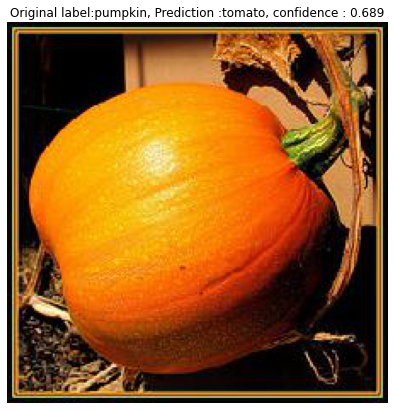

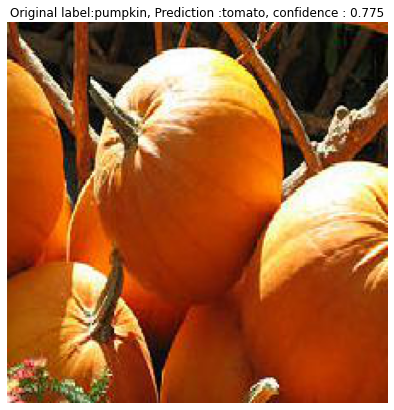

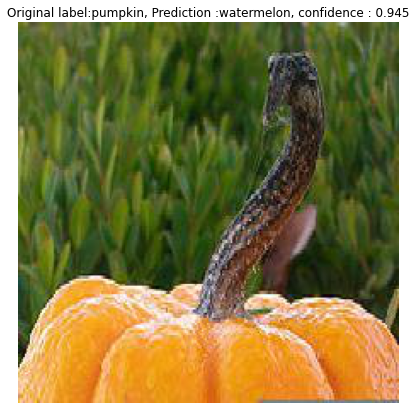

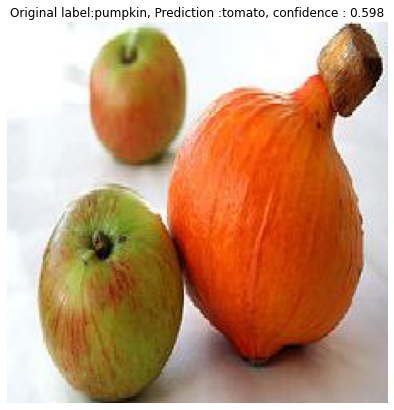

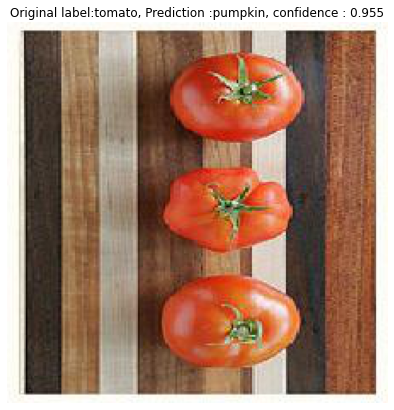

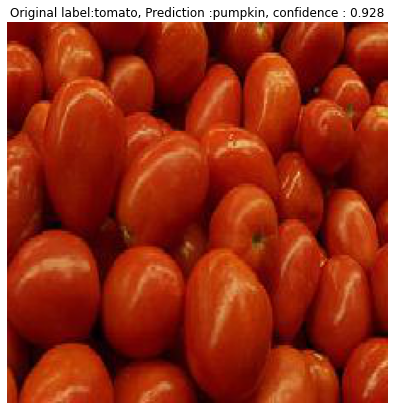

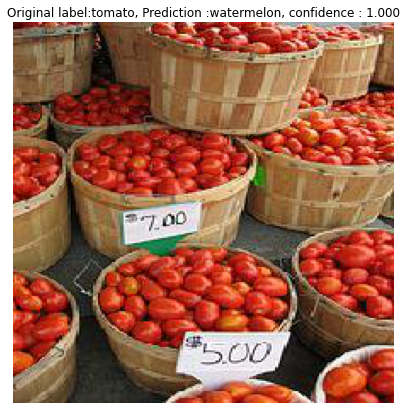

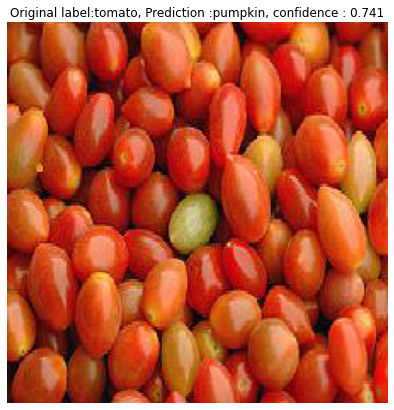

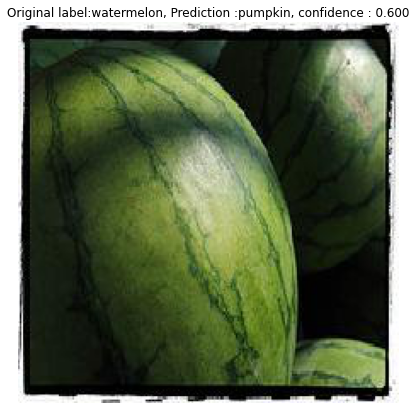

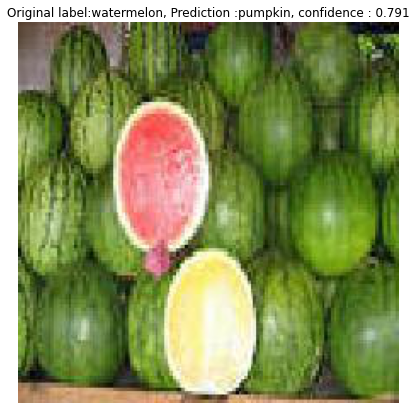

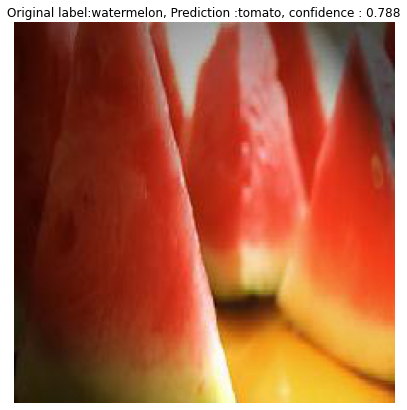

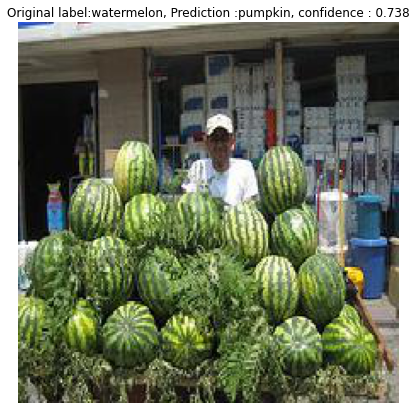

In [12]:
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(validation_generator, predictions)

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames)

## Experiment 2: Train Last 4 layers without data augmentation

<h3>1. Freezing all layers</h3>

Create the model setting include_top parameter to False in order to exclude the fully-connected layers at the top of the network.

In [13]:
#Load the VGG model
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fada8ac5250> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada8686850> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fac9c13a890> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fada868d5d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada8692a90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada869ea50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fada869eb10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada86a1090> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada86aca90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada86b3250> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fada86b89d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

<h3>2. Prepare the training and validation data</h3>

In [14]:
# No data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


<h3>3. Train the last 4 layers without data augmentation</h3>

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6.0 steps, validate for 15.0 steps
Epoch 1/20
6/6 [==============================] - 4s 732ms/step - loss: 2.3012 - acc: 0.3417 - val_loss: 0.9952 - val_acc: 0.5333
Epoch 2/20
6/6 [==============================] - 4s 624ms/step - loss: 1.2179 - acc: 0.5083 - val_loss: 1.4391 - val_acc: 0.3467
Epoch 3/20
6/6 [==============================] - 4s 623ms/step - loss: 0.8701 - acc: 0.6233 - val_loss: 0.4793 - val_acc: 0.8400
Epoch 4/20
6/6 [==============================] - 4s 624ms/step - loss: 0.5687 - acc: 0.7883 - val_loss: 0.6534 - val_acc: 0.6933
Epoch 5/20
6/6 [==============================] - 4s 624ms/step - loss: 0.4358 - acc: 0.8467 - val_loss: 0.2061 - val_acc: 0.9467
Epoch 6/20
6/6 [==============================] - 4s 624ms/step - loss: 0.1804 - acc: 0.9350 - val_loss: 0.2713 - val_acc: 0.9267
Epoch 7/20
6/6 [==============================] - 4s 624ms/step - loss: 0.2997 - acc: 0.8800 - val_loss: 0.1649 - val_acc: 0.

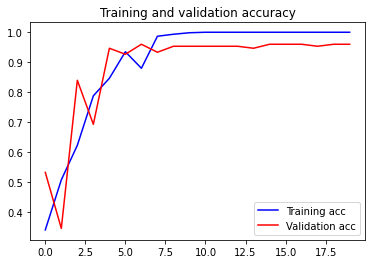

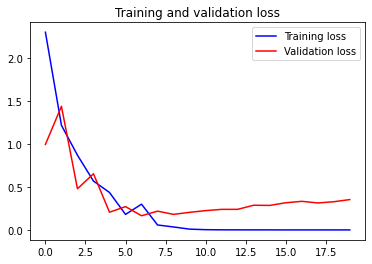

In [15]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the model
model.save('last4_layers.h5')

# Run the function to illustrate accuracy and loss
visualize_results(history)

<h3>4. Show the errors</h3>

15/15 [==============================] - 1s 53ms/step
The list of classes:  ['pumpkin', 'tomato', 'watermelon']
Number of errors = 6/150


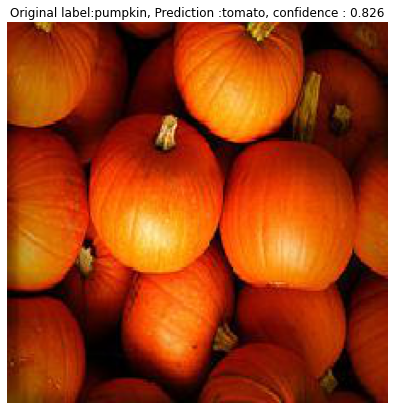

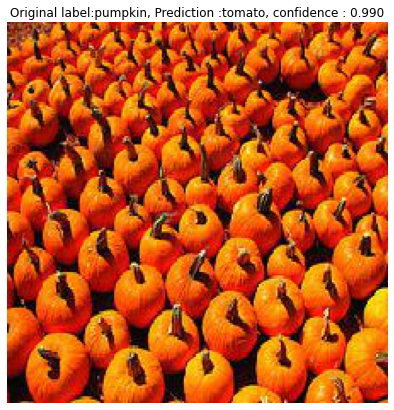

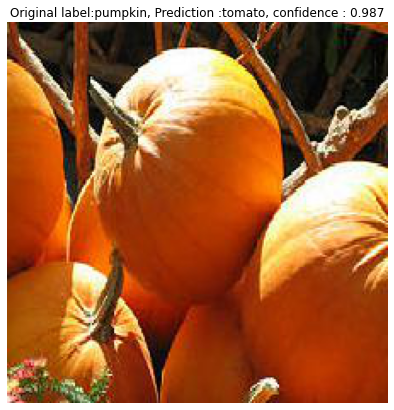

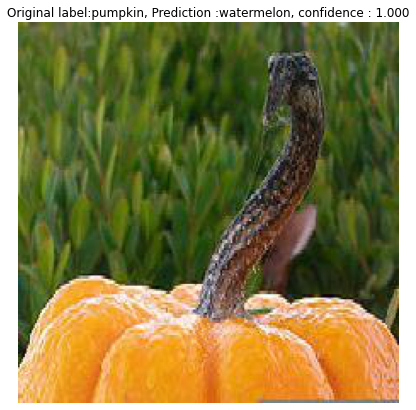

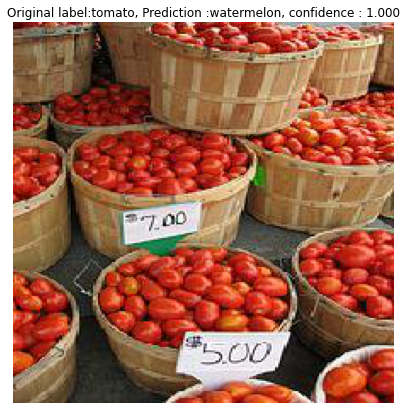

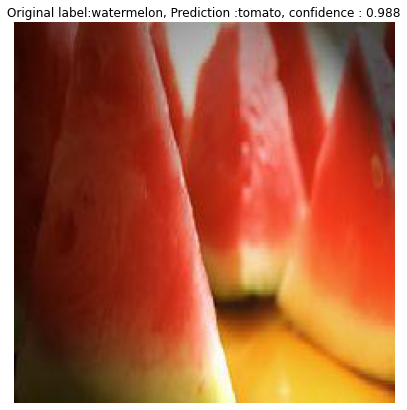

In [16]:
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(validation_generator, predictions)

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames)

## Experiment 3: Train last 4 layers with data augmentation 

<h3>1. Freezing all layers</h3>

Create the model setting include_top parameter to False in order to exclude the fully-connected layers at the top of the network.

In [17]:
#Load the VGG model
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fada86f95d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada8b9a850> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada870e450> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fada8b98210> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada8bab490> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada8b97bd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fada8bb2650> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada8b8ac50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada87a9c10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fada87a9cd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fada87b6490> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

<h3>2. Prepare the training and validation data</h3>

In [18]:
# generate batches of train transformed images and labels
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 50
val_batchsize = 10

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


<h3>3. Visualizing the datasets</h3>

The shape of train images: (224, 224, 3)


Text(0.5, 1.0, 'Train class name: pumpkin')

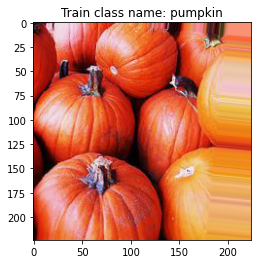

In [19]:
# Choose the image index for the visualization
image_id = 5

# Get the train image shape 
print("The shape of train images: {}".format(train_generator[image_id][0][0].shape))

# Visualize the train image example
plt.imshow(train_generator[image_id][0][0])

# Show the train image class
plt.title("Train class name: {}".format(get_class_name(train_generator, image_id)))

<h3>4. Train the model. Here we will be using the imageDataGenerator for data augmentation</h3>

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12.0 steps, validate for 15.0 steps
Epoch 1/40
12/12 [==============================] - 6s 484ms/step - loss: 1.4841 - acc: 0.4100 - val_loss: 1.0167 - val_acc: 0.3333
Epoch 2/40
12/12 [==============================] - 5s 429ms/step - loss: 0.7673 - acc: 0.6683 - val_loss: 0.3477 - val_acc: 0.8800
Epoch 3/40
12/12 [==============================] - 5s 437ms/step - loss: 0.4770 - acc: 0.8200 - val_loss: 1.0165 - val_acc: 0.7400
Epoch 4/40
12/12 [==============================] - 5s 445ms/step - loss: 0.3649 - acc: 0.8667 - val_loss: 0.2347 - val_acc: 0.9400
Epoch 5/40
12/12 [==============================] - 5s 439ms/step - loss: 0.3161 - acc: 0.8800 - val_loss: 0.2421 - val_acc: 0.9400
Epoch 6/40
12/12 [==============================] - 5s 438ms/step - loss: 0.1201 - acc: 0.9583 - val_loss: 0.8477 - val_acc: 0.7867
Epoch 7/40
12/12 [==============================] - 5s 433ms/step - loss: 0.1652 - acc: 0.9517 - val_loss: 0.334

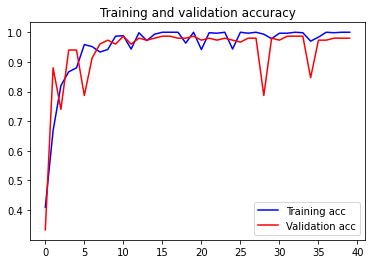

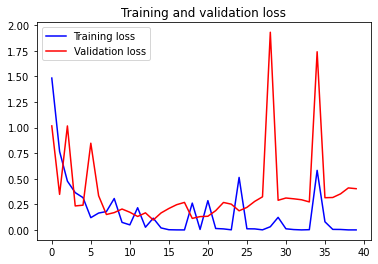

In [20]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the model
model.save('da_last4_layers.h5')

# Run the function to illustrate accuracy and loss
visualize_results(history)

<h3>5. Show the errors</h3>

15/15 [==============================] - 1s 52ms/step
The list of classes:  ['pumpkin', 'tomato', 'watermelon']
Number of errors = 3/150


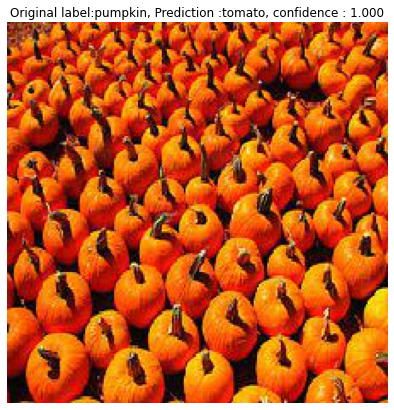

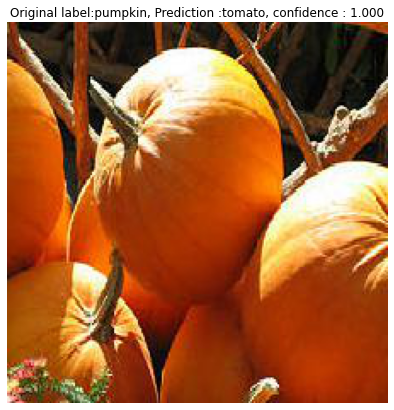

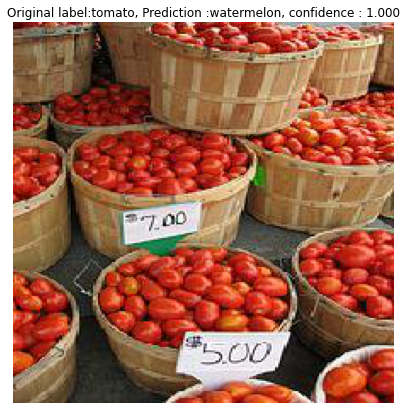

In [21]:
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(validation_generator, predictions)

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames)